# 📈 Lokesh Machines Stock Price Prediction using Multivariate LSTM
Predict future stock prices of Lokesh Machines (LOKESHMACH.NS) using LSTM and visualize predictions with Matplotlib.

In [39]:
# Import required libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import ta

## Loading and Preprocessing the Dataset

In [2]:
# Load the dataset
# Choose the stock ticker symbol
ticker = "LOKESHMACH.NS"

# Download the historical data from Yahoo Finance
df = yf.download(ticker, start='2015-01-01', end='2025-04-30')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


Price,Close,High,Low,Open,Volume
Ticker,LOKESHMACH.NS,LOKESHMACH.NS,LOKESHMACH.NS,LOKESHMACH.NS,LOKESHMACH.NS
Date,,,,,
2015-01-01,36.613026,38.389402,34.195187,35.034029,4091
2015-01-02,37.501217,38.192030,35.724844,36.316967,4332
2015-01-05,36.070248,38.488090,35.774186,37.402530,1044
2015-01-06,36.267624,38.290715,34.737970,35.774187,2082
2015-01-07,35.971561,38.488090,33.997813,35.527467,2058


In [4]:
# Checking number of missing Values
print("\nMissing values in each columns:")
df.isnull().sum()


Missing values in each columns:


Price   Ticker       
Close   LOKESHMACH.NS    0
High    LOKESHMACH.NS    0
Low     LOKESHMACH.NS    0
Open    LOKESHMACH.NS    0
Volume  LOKESHMACH.NS    0
dtype: int64

In [5]:
# Checking Datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2547 entries, 2015-01-01 to 2025-04-29
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (Close, LOKESHMACH.NS)   2547 non-null   float64
 1   (High, LOKESHMACH.NS)    2547 non-null   float64
 2   (Low, LOKESHMACH.NS)     2547 non-null   float64
 3   (Open, LOKESHMACH.NS)    2547 non-null   float64
 4   (Volume, LOKESHMACH.NS)  2547 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 119.4 KB


In [6]:
# Date column is the index

In [7]:
# Scale the data and change it into dataframe
scaler = MinMaxScaler(feature_range=(0, 1))
scale = scaler.fit_transform(df[df.columns])
df_scaled = pd.DataFrame(scale, columns = df.columns, index = df.index)

In [8]:
df_scaled

Price,Close,High,Low,Open,Volume
Ticker,LOKESHMACH.NS,LOKESHMACH.NS,LOKESHMACH.NS,LOKESHMACH.NS,LOKESHMACH.NS
Date,,,,,
2015-01-01,0.049022,0.050970,0.048116,0.044419,0.000781
2015-01-02,0.050965,0.050541,0.051589,0.047229,0.000827
2015-01-05,0.047835,0.051184,0.051701,0.049606,0.000199
2015-01-06,0.048267,0.050756,0.049348,0.046040,0.000397
2015-01-07,0.047619,0.051184,0.047668,0.045500,0.000393
...,...,...,...,...,...
2025-04-23,0.353281,0.348964,0.369398,0.352502,0.001426
2025-04-24,0.360958,0.356580,0.377367,0.360188,0.001685


## Visualization of the dataset

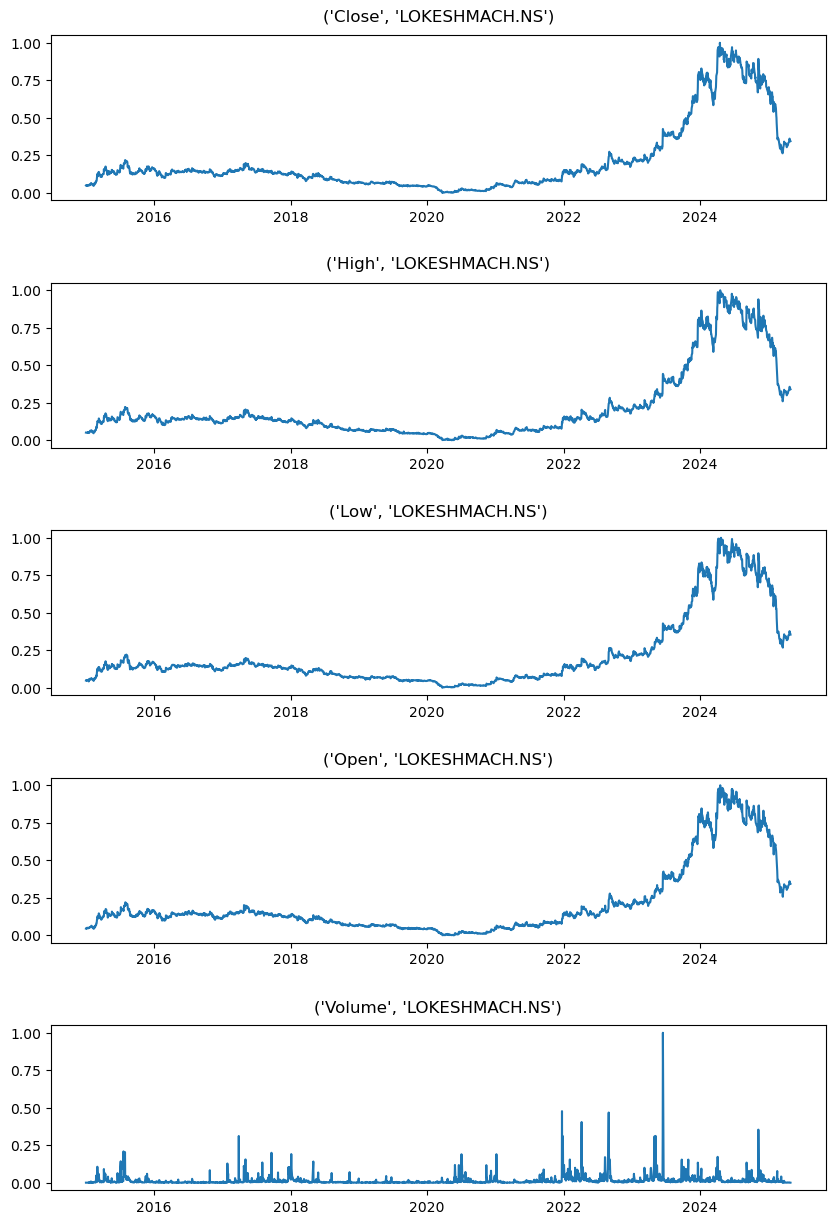

In [9]:
fig, axes = plt.subplots(nrows=len(df_scaled.columns), figsize=(10, 15))
plt.subplots_adjust(hspace=0.5)

for axis, col in zip(axes, df_scaled.columns):
    axis.plot(df_scaled[col])
    axis.set_title(col, pad=10)

## Building LSTM Model

In [10]:
def create_sequence(data, sequence_length):
    """Create time-series sequences for LSTM input"""
    
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data.iloc[i-sequence_length:i].values)
        y.append(data.iloc[i].values)
        
    return np.array(X), np.array(y)

In [11]:
sequence_length = 100
X, y = create_sequence(df_scaled, sequence_length)

In [12]:
X.shape

(2447, 100, 5)

In [13]:
y.shape

(2447, 5)

In [14]:
# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
def build_model(input_shape):
    """Construct multivariate LSTM model"""
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape= input_shape),
        Dropout(0.3),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(100, return_sequences=False),
        Dropout(0.3),
        Dense(y_train.shape[1]),
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['RootMeanSquaredError'])
    return model

In [17]:
# Model setup
model = build_model((X_train.shape[1], X_train.shape[2]))
model.save("lstm_stock_model.keras")

In [18]:
callbacks = EarlyStopping(monitor = 'val_loss' , patience = 5, restore_best_weights = True)

In [19]:
lstm_model = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 288ms/step - RootMeanSquaredError: 0.1118 - loss: 0.0143 - val_RootMeanSquaredError: 0.0344 - val_loss: 0.0012
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 39s 264ms/step - RootMeanSquaredError: 0.0570 - loss: 0.0033 - val_RootMeanSquaredError: 0.0340 - val_loss: 0.0012
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 265ms/step - RootMeanSquaredError: 0.0500 - loss: 0.0025 - val_RootMeanSquaredError: 0.0428 - val_loss: 0.0018
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 276ms/step - RootMeanSquaredError: 0.0492 - loss: 0.0024 - val_RootMeanSquaredError: 0.0349 - val_loss: 0.0012
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - RootMeanSquaredError: 0.0499 - loss: 0.0025 - val_RootMeanSquaredError: 0.0323 - val_loss: 0.0010
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 38s 271ms/step - RootMeanSquaredError: 0.0421 - loss: 0.0018 - val_RootMeanSquaredError: 0.0285 - val_loss: 8.0984e-04
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 278ms/step - RootMeanSquaredE

In [21]:
prediction = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step


## Forecasting the data

In [22]:
prediction

array([[0.8467955 , 0.8616987 , 0.8515038 , 0.86898077, 0.02074146],
       [0.00742893, 0.00796001, 0.01154848, 0.00302556, 0.00856627],
       [0.04227152, 0.04286983, 0.04554801, 0.03878573, 0.01135596],
       ...,
       [0.12602836, 0.12749615, 0.12828565, 0.1252838 , 0.01971383],
       [0.16186523, 0.16419885, 0.1645129 , 0.16274786, 0.02804058],
       [0.13279606, 0.13583282, 0.13818792, 0.13400888, 0.03302961]],
      dtype=float32)

In [29]:
# inverse scaling
prediction = scaler.inverse_transform(prediction)
y_test_rescaled = scaler.inverse_transform(y_test)

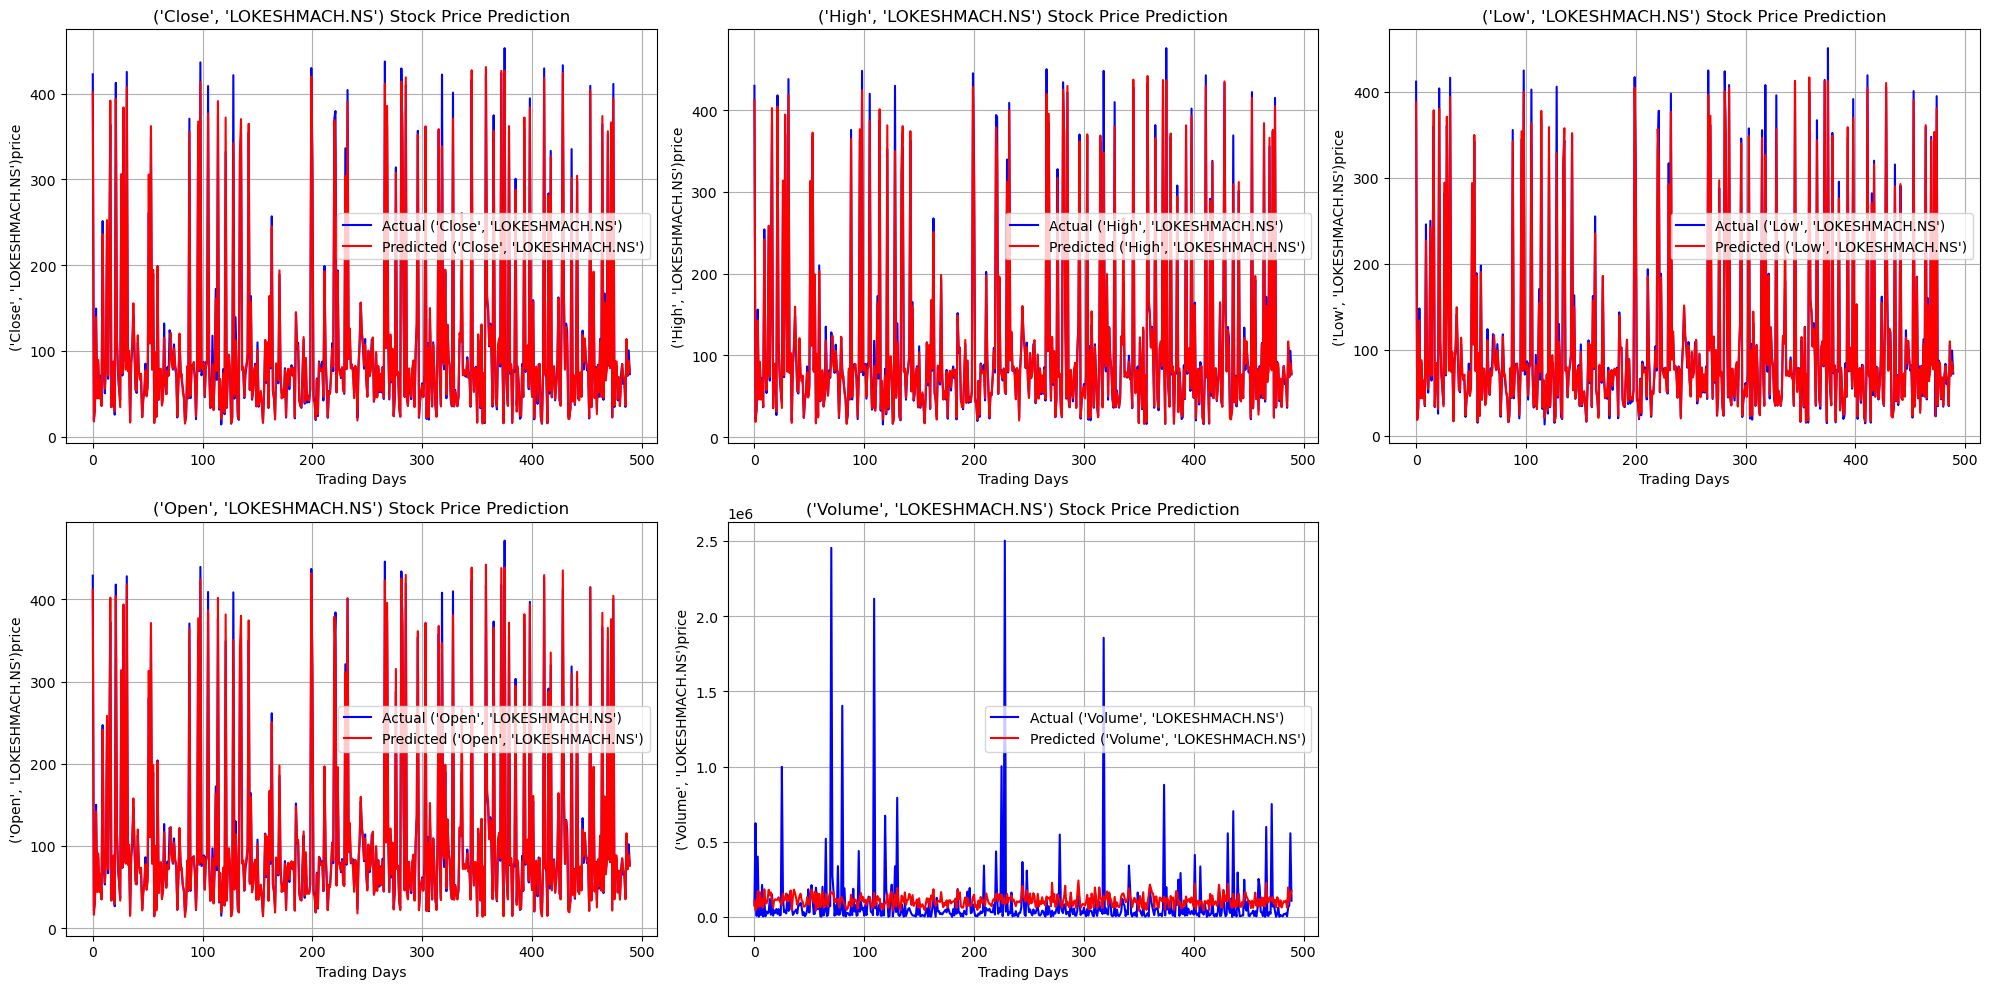

In [30]:
# plot the results
plt.figure(figsize = (20,10))

for i , col in enumerate(df_scaled.columns):
    plt.subplot(2,3,i+1)
    plt.plot(y_test_rescaled[:,i], label= f'Actual {col}', color='blue')
    plt.plot(prediction[:,i], label= f'Predicted {col}', color='red')
    plt.title(f'{col} Stock Price Prediction')
    plt.xlabel('Trading Days')
    plt.ylabel(f'{col}price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

## Visualize MA & RSI

In [31]:
df["MA50"] = df["Close"].rolling(window=50).mean()  # 50-day moving average
df["RSI"] = 100 - (100 / (1 + df["Close"].pct_change().rolling(window=14).mean()))

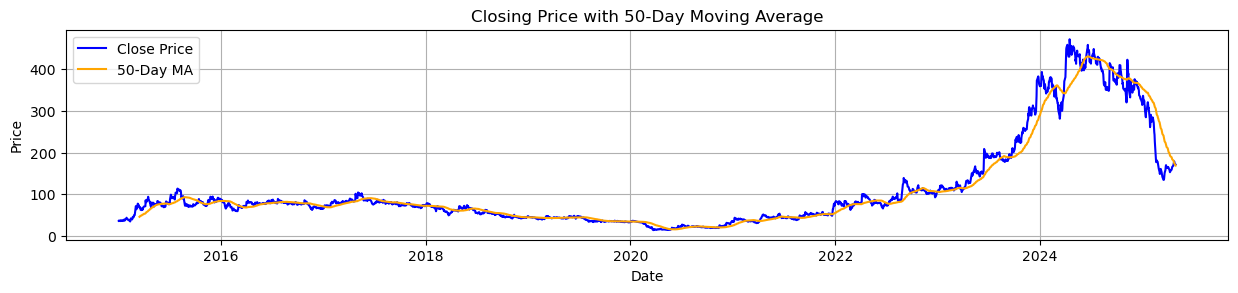

In [42]:
# Moving Average Plot
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(df["Close"], label="Close Price", color='blue')
plt.plot(df["MA50"], label="50-Day MA", color='orange')
plt.title("Closing Price with 50-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)


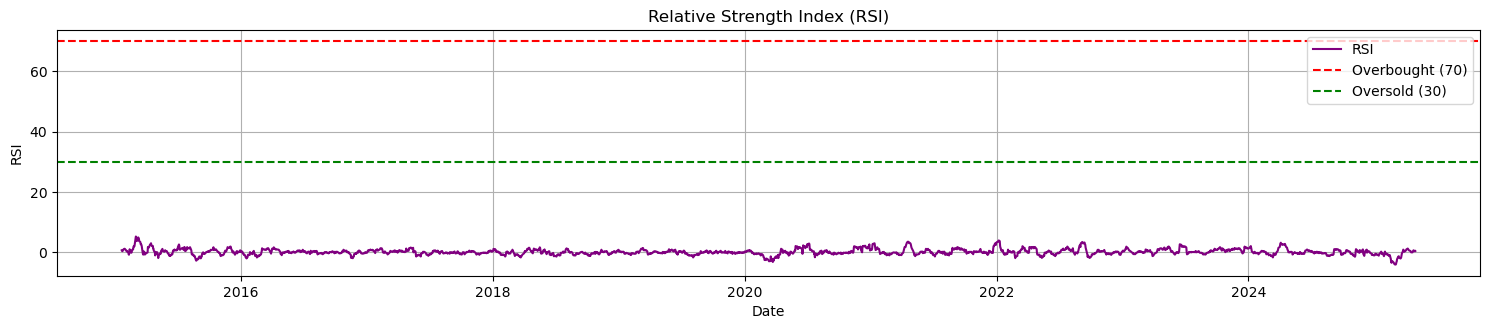

In [43]:
# RSI Plot
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 2)
plt.plot(df["RSI"], label="RSI", color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
plt.title("Relative Strength Index (RSI)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluation Metrics

In [44]:
# Evaluate the model with MAE and R² Score
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate only 'Close' price (index 0 in your normalized columns)
actual_close = y_test_rescaled[:, 0]
predicted_close = prediction[:, 0]

mae = mean_absolute_error(actual_close, predicted_close)
r2 = r2_score(actual_close, predicted_close)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 5.1157
R² Score: 0.9905
